# Mini challenge - NPM3D

In [12]:
# @title Imports {display-mode: "form"}

import os
from datetime import datetime
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import jaccard_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KDTree

In [13]:
is_on_colab = False  # @param

In [14]:
if is_on_colab:
    try:
        from google.colab import drive

        drive.mount("/content/drive", force_remount=True)
    except ImportError:
        pass
    folder_path = "/content/drive/MyDrive/master/mva/s2/npm3d/TP3_materials/"  # @param
    os.chdir(folder_path)

In [15]:
from src import (
    FeaturesExtractor,
    print_tensors_size_in_memory,
    timeit,
    checkpoint,
)

## I/O

In [16]:
# @title Importing the data {display-mode: "form"}

training_path = "./data/training"
test_path = "./data/test"

f_extractor = FeaturesExtractor()

train_features, train_labels, test_features, test_labels = f_extractor.extract_point_clouds(
    training_path, "MiniLille1.ply"
)

submission_set = f_extractor.extract_point_cloud_no_label(test_path)

Reading file MiniParis1.ply
Reading file MiniLille1.ply
Reading file MiniLille2.ply


In [17]:
@timeit
def add_neighborhoods(point_cloud: np.ndarray, n_neighbors: int) -> np.ndarray:
    """
    Replace the [x, y, z] coordinates for each point by a 2d array
    of the coordinates + distances to current point of the k nearest neighbors.
    """
    kdtree = KDTree(point_cloud)
    distances, neighborhoods = kdtree.query(point_cloud, k=n_neighbors)
    resulting_cloud = np.zeros((point_cloud.shape[0], n_neighbors, 4))
    for idx in range(point_cloud.shape[0]):
        resulting_cloud[idx] = np.hstack(
            (point_cloud[neighborhoods[idx]], distances[idx][:, None])
        )

    return resulting_cloud

In [ ]:
# @title Exporting the data {display-mode: "form"}


@timeit
def predict(
    model: nn.Module,
    features: np.ndarray,
    file_path: str = f"submissions/dl-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.txt",
) -> None:
    """
    Infers the model on the submission dataset and saves the prediction on a file.
    """
    with torch.no_grad():
        timer = checkpoint()
        # running the model slice by slice to prevent our GPU from overloading
        for idx, split in enumerate(np.array_split(features, 500)):
            arr_slice = torch.from_numpy(split).type(torch.FloatTensor).to(device)
            print_tensors_size_in_memory(arr_slice)
            predictions = torch.argmax(
                model(arr_slice),
                dim=1,
            )
            np.savetxt(file_path.replace(".txt", f"_{idx}.txt"), predictions, fmt="%d")
            timer(f"Time spent on slice {idx}")

In [19]:
# train_features = add_neighborhoods(train_features, 30)
# test_features = add_neighborhoods(test_features, 30)
# submission_set = add_neighborhoods(submission_set, 30)

Function add_neighborhoods took 0.05 seconds
Function add_neighborhoods took 0.02 seconds
Function add_neighborhoods took 39.57 seconds


## Pipelines

In [20]:
# Get cpu or gpu device for training.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using {device} device")

Using cpu device


In [21]:
def train(dataloader, model, loss_fn, optimizer, print_loss: bool = True) -> float:
    size = len(dataloader.dataset)
    model.train(True)

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        # computing the prediction
        pred = model(x)
        # pred = torch.argmax(pred, dim=1)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()

        if batch % 50 == 0 and print_loss:
            loss_val, current = loss.item(), batch * len(x)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

    return loss.item()

In [22]:
def test(dataloader, model, loss_fn) -> Tuple[float, float]:
    num_batches = len(dataloader)
    model.eval()
    test_loss, jac_score = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)

            test_loss += loss_fn(pred, y).item()
            jac_score += jaccard_score(
                y.detach().cpu().numpy(),
                torch.argmax(pred, dim=1).detach().cpu().numpy(),
                average="micro",
            )

    test_loss /= num_batches
    jac_score /= num_batches

    print(
        f"Test Error: \n Avg loss:          {test_loss:>8f} \n Avg Jaccard score: {jac_score:>8f}"
    )

    return test_loss, jac_score

In [23]:
def plot_performance(loss_train, loss_test, jac_score):
    """
    Plots three graphs describing the evolution of three metrics duering the training process.
    """
    # subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # loss on training dataset
    ax1.plot(loss_train, color="red")
    ax1.set_title("Model loss on training set")
    ax1.set_ylabel("Loss on training set")
    ax1.set_xlabel("Epoch")

    # Jaccard score on validation dataset
    ax2.plot(jac_score, color="red")
    ax2.set_title("Jaccard score on validation set")
    ax2.set_ylabel("Jaccard score on validation set")
    ax2.set_xlabel("Epoch")

    # loss on validation dataset
    ax3.plot(loss_test, color="red")
    ax3.set_title("Model loss on validation set")
    ax3.set_ylabel("Loss on validation set")
    ax3.set_xlabel("Epoch")

    plt.show()

In [ ]:
def check_few_batches(model, train_dataloader, n_batches: int = 5):
    """
    Displays the accuracy and the confusion matrix on a few batches.
    """
    with torch.no_grad():
        for i, (x, y) in enumerate(train_dataloader):
            pred = torch.argmax(model(x.to(device)).cpu(), dim=1)
            print(f"Accuracy on batch {i}: {accuracy_score(y, pred)}")
            ConfusionMatrixDisplay.from_predictions(y, pred)
            if i == n_batches:
                break

In [24]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_features), torch.Tensor(train_labels).type(torch.LongTensor)
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
)
test_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(test_features), torch.Tensor(test_labels).type(torch.LongTensor)
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
)

## Models

In [25]:
class PointNet(nn.Module):
    def __init__(self, classes=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(64, 64, 1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(64, 64, 1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(64, 128, 1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(128, 1024, 1),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.MaxPool1d(1024),
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, classes),
            nn.Softmax(dim=-1),
        )

    def forward(self, x):
        return self.net(x)

In [26]:
model = PointNet().to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

PointNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
  (conv5): Conv2d(128, 1024, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1024, out_features=512, bi

## Experiments

In [27]:
max_epochs = 800
epoch = 0

loss_list_train, loss_list_test, jac_score_list_test = [], [], []
test_loss, val_no_impv, halving = 10, 0, False

In [28]:
# you can stop this loop with a KeyboardInterrupt and rerun it to pick up where you left off
timer = checkpoint()
while epoch < max_epochs:
    try:
        print(f"\nEpoch {epoch + 1}\n-------------------------------")

        loss_train = train(train_dataloader, model, loss_fn, optimizer)
        scheduler.step()
        prev_test_loss = test_loss
        test_loss, jac_score = test(test_dataloader, model, loss_fn)

        timer(f"Epoch {epoch + 1} lasted for")

        loss_list_train.append(loss_train)
        loss_list_test.append(test_loss)
        jac_score_list_test.append(jac_score)

    except KeyboardInterrupt:
        print("\nExecution stopped.")
        break

    epoch += 1

print("Done!")


Epoch 1
-------------------------------
loss: 1.946954  [    0/ 5500]
loss: 2.379067  [ 1000/ 5500]
loss: 2.206805  [ 2000/ 5500]
loss: 1.600179  [ 3000/ 5500]
loss: 2.704869  [ 4000/ 5500]
loss: 1.554513  [ 5000/ 5500]
Test Error: 
 Avg loss: 1.782085 
 Avg Jaccard score: 0.219307
Epoch 1 lasted for 696.2746 s.

Epoch 2
-------------------------------
loss: 1.670490  [    0/ 5500]
loss: 1.580961  [ 1000/ 5500]
loss: 1.637584  [ 2000/ 5500]
loss: 1.384614  [ 3000/ 5500]
loss: 1.175327  [ 4000/ 5500]
loss: 0.701710  [ 5000/ 5500]
Test Error: 
 Avg loss: 1.691276 
 Avg Jaccard score: 0.343476
Epoch 2 lasted for 51.5735 s.

Epoch 3
-------------------------------
loss: 0.893242  [    0/ 5500]
loss: 0.936972  [ 1000/ 5500]
loss: 1.189770  [ 2000/ 5500]
loss: 0.673967  [ 3000/ 5500]
loss: 0.878343  [ 4000/ 5500]
loss: 0.575604  [ 5000/ 5500]
Test Error: 
 Avg loss: 2.027018 
 Avg Jaccard score: 0.378216
Epoch 3 lasted for 51.8114 s.

Epoch 4
-------------------------------
loss: 0.645512  

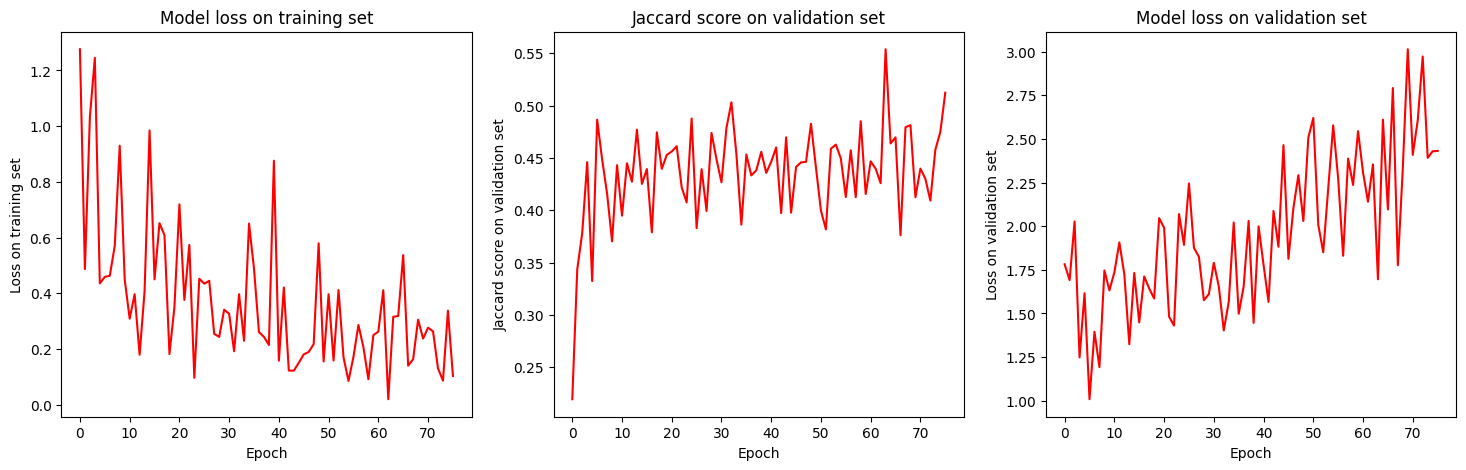

In [29]:
plot_performance(loss_list_train, loss_list_test, jac_score_list_test)

Accuracy on batch 0: 0.95
Accuracy on batch 1: 0.95
Accuracy on batch 2: 0.9
Accuracy on batch 3: 0.9
Accuracy on batch 4: 0.8
Accuracy on batch 5: 1.0


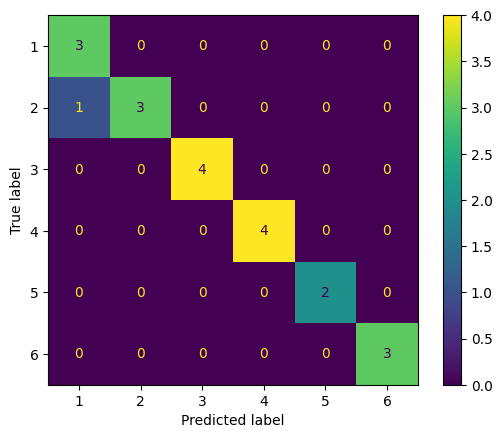

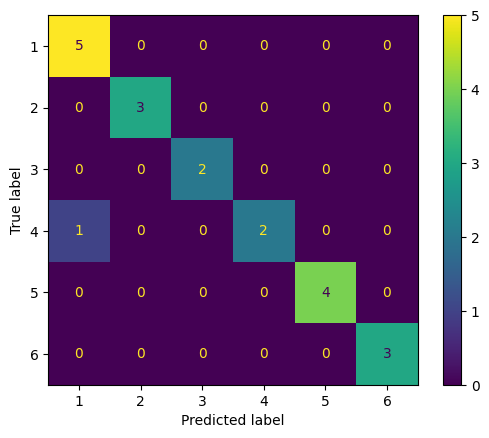

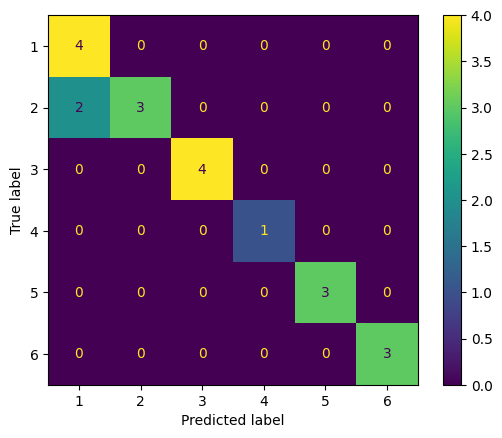

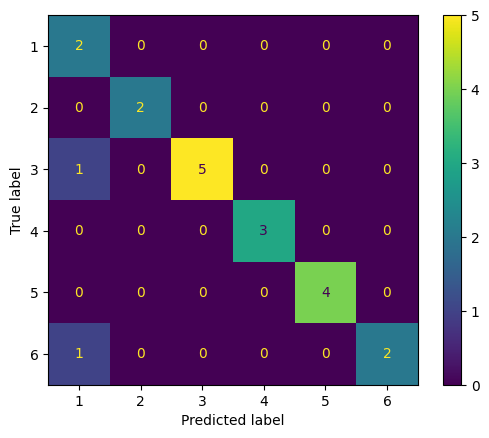

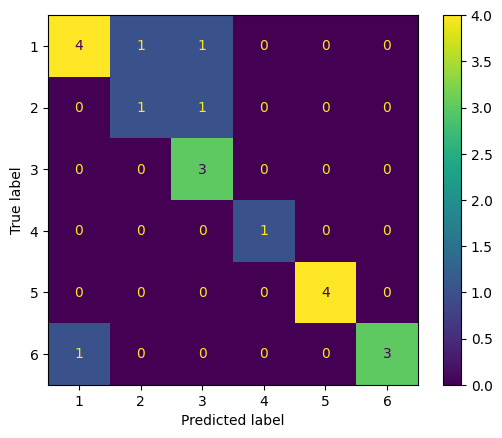

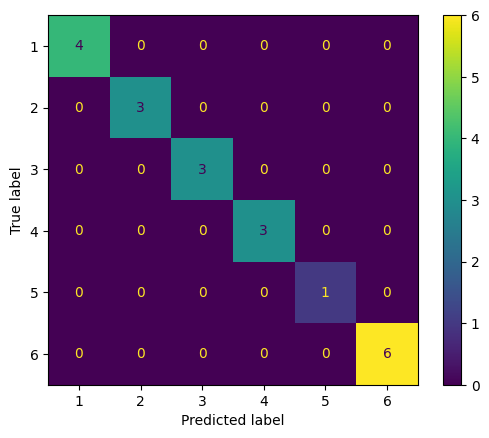

In [30]:
check_few_batches(model, train_dataloader)

In [31]:
# @title Saving the trained model {display-mode: "form"}

torch.save(model.state_dict(), f"submissions/model-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.pth")

In [32]:
predict(model, submission_set)

Size in memory of tensor arr_slice: 2.8194 MB
Time spent on slice 0 5083.9548 s.
Size in memory of tensor arr_slice: 2.8194 MB


KeyboardInterrupt: 